<a href="https://colab.research.google.com/github/sangeetakar/Identifying-latent-topics-in-a-collection-of-news-articles-using-Latent-Dirichlet-Allocation-LDA-/blob/main/LDA2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
!pip install -U seaborn
from seaborn import lineplot

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.13.1
    Uninstalling seaborn-0.13.1:
      Successfully uninstalled seaborn-0.13.1


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d uciml/news-aggregator-dataset

Dataset URL: https://www.kaggle.com/datasets/uciml/news-aggregator-dataset
License(s): CC0-1.0
 79% 22.0M/28.0M [00:00<00:00, 113MB/s] 
100% 28.0M/28.0M [00:00<00:00, 119MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/news-aggregator-dataset.zip', 'r')

zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string
import multiprocessing

news = pd.read_csv("uci-news-aggregator.csv")

# Convert date
news['TIMESTAMP'] = pd.to_datetime(news['TIMESTAMP'], unit='ms')

# columns.
news[["TITLE", "PUBLISHER", "CATEGORY", "HOSTNAME", "TIMESTAMP"]].head()

,TITLE,PUBLISHER,CATEGORY,HOSTNAME,TIMESTAMP
0,"Fed official says weak data caused by weather,...",Los Angeles Times,b,www.latimes.com,2014-03-10 16:52:50.698
1,Fed's Charles Plosser sees high bar for change...,Livemint,b,www.livemint.com,2014-03-10 16:52:51.207
2,US open: Stocks fall after Fed official hints ...,IFA Magazine,b,www.ifamagazine.com,2014-03-10 16:52:51.550
3,"Fed risks falling 'behind the curve', Charles ...",IFA Magazine,b,www.ifamagazine.com,2014-03-10 16:52:51.793
4,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,Moneynews,b,www.moneynews.com,2014-03-10 16:52:52.027


In [ ]:
def date_printer(date):
    return "{}/{}/{}".format(date.day, date.month, date.year)

start, end = news['TIMESTAMP'].min(), news['TIMESTAMP'].max()
print("dataset timeline starts at {} and ends at {}".format(date_printer(start), date_printer(end)))

dataset timeline starts at 10/3/2014 and ends at 28/8/2014


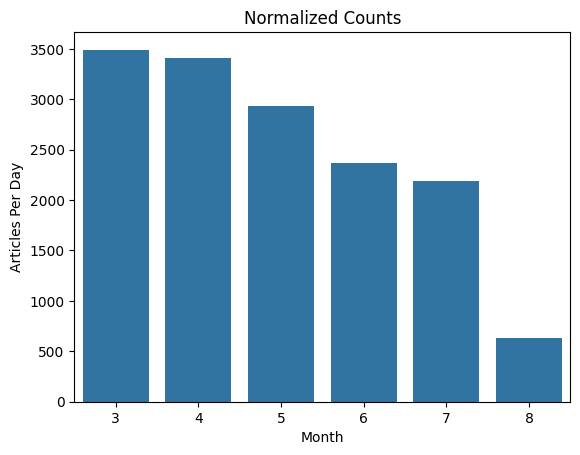

In [ ]:
news['MONTH'] = news['TIMESTAMP'].apply(lambda date: date.month)
news['DAY'] = news['TIMESTAMP'].apply(lambda date: date.day)

# Some months have 30 and others have 30 days. The first and last months in our dataset and not whole.
month_days = {
    3: 21,
    4: 30,
    5: 31,
    6: 30,
    7: 31,
    8: 27
}
articles_per_day = {}
for month in month_days:
    n_articles = len(news[news['MONTH'] == month])
    articles_per_day[month] = n_articles / month_days[month]

ax = sns.barplot(x=list(articles_per_day.keys()), y=list(articles_per_day.values()))
ax.set_title("Normalized Counts")
ax.set_xlabel("Month")
ax.set_ylabel("Articles Per Day")
plt.show()

<ipython-input-9-4c4f528d7744>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([cat_map[label.get_text()] for label in ax.get_xticklabels()], rotation=45)


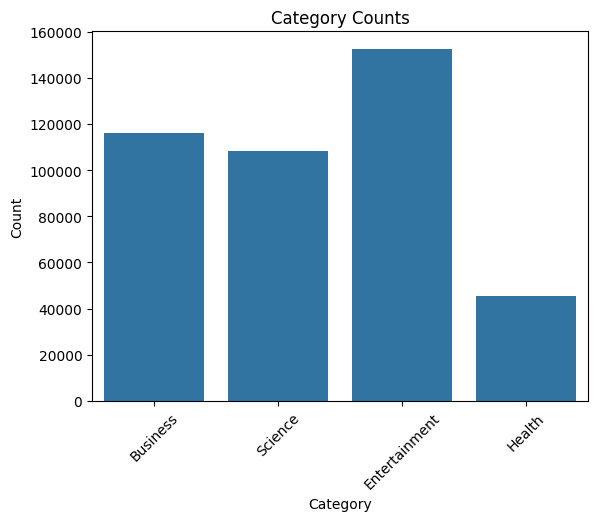

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the category mapping
cat_map = {
    'b': 'Business',
    't': 'Science',
    'e': 'Entertainment',
    'm': 'Health'
}

# Plot the count of each category
ax = sns.countplot(x='CATEGORY', data=news)

# Set the title and labels for the plot
ax.set_title("Category Counts")
ax.set_xlabel("Category")
ax.set_ylabel("Count")

# Manipulate the x-axis labels
ax.set_xticklabels([cat_map[label.get_text()] for label in ax.get_xticklabels()], rotation=45)

# Show the plot
plt.show()




In [ ]:
from collections import Counter

# style print output
def emphasize(s):

    red = '\x1b[1;31m'
    stop = '\x1b[0m'
    return red + str(s) + stop

nunique = news['PUBLISHER'].nunique()
print("There are {} different publishers. Below some of the most common:".format(emphasize(nunique)))
for key, value in Counter(news['PUBLISHER']).most_common(5):
    print("   {} posted {} articles".format(emphasize(key), emphasize(value)))


There are 10985 different publishers. Below some of the most common:
   Reuters posted 3902 articles
   Huffington Post posted 2455 articles
   Businessweek posted 2395 articles
   Contactmusic.com posted 2334 articles
   Daily Mail posted 2254 articles


In [ ]:
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

def tokenize(s, lemmatize=True, decode=False):

    # NLTK data
    try:
        if decode:
            s = s.decode("utf-8")
        tokens = word_tokenize(s.lower())
    except LookupError:
        nltk.download('punkt')
        tokenize(s)



    ignored = stopwords.words("english") + [punct for punct in string.punctuation]
    clean_tokens = [token for token in tokens if token not in ignored]

    #lemmatize the output to reduce the number of unique words and address overfitting.
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        return [lemmatizer.lemmatize(token) for token in clean_tokens]
    return clean_tokens


def test_tokenize():

    # With lemmatization
    text = "Mr. X correctly diagnosed his patients."
    expected_result = ['mr.', 'x', 'correctly', 'diagnosed', 'patient']
    assert tokenize(text) == expected_result

    # Without lemmatization
    expected_result = ['mr.', 'x', 'correctly', 'diagnosed', 'patients']
    assert tokenize(text, lemmatize=False) == expected_result

test_tokenize()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder

# Bag of Words Representation using tokenizer.
vectorizer = CountVectorizer(lowercase=False, tokenizer=tokenize)
x = vectorizer.fit_transform(news['TITLE'])

# Create numerical labels.
encoder = LabelEncoder()
y = encoder.fit_transform(news['CATEGORY'])

encoder_mapping = dict(zip(encoder.transform(encoder.classes_), encoder.classes_))

# Split into a training and test set.
seed = 42
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
from sklearn.ensemble import RandomForestClassifier

def report_accuracy(trained_clf):
    train_score = trained_clf.score(x_train, y_train)
    test_score = trained_clf.score(x_test, y_test)
    print("Training set accuracy score is: {}".format(emphasize(train_score)))
    print("Test set accuracy score is: {}".format(emphasize(test_score)))

n_cores = max(multiprocessing.cpu_count(), 1)

rf = RandomForestClassifier(n_jobs=n_cores)
rf.fit(x_train, y_train)
report_accuracy(rf)


KeyboardInterrupt: 

In [ ]:
#confusionmatrix
from sklearn.metrics import confusion_matrix
import numpy as np

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14, normalize=False):

    if normalize:
        confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
        title = 'Normalized Confusion Matrix'
    else:
        fmt = 'd'
        title = 'Confusion Matrix'

    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    fig = plt.figure(figsize=figsize)
    heatmap = sns.heatmap(df_cm, annot=True, fmt=fmt)

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    heatmap.set_ylabel('True label')
    heatmap.set_xlabel('Predicted label')
    heatmap.set_title(title)
    return fig

conf_mat = confusion_matrix(y_test, rf.predict(x_test))

# readable labels
labels = [cat_map[encoder_mapping[label]] for label in sorted(encoder_mapping.keys())]
ax = print_confusion_matrix(conf_mat, labels, normalize=True)
plt.show()

In [ ]:


news['WEEK'] = news['TIMESTAMP'].apply(lambda date: date.week)

# Aggregate by week
aggregated = news[['WEEK', 'MONTH', 'CATEGORY']]
grouped = aggregated.groupby(['WEEK', 'CATEGORY']).size().reset_index(name='article_count')
grouped['CATEGORY'] = grouped['CATEGORY'].apply(lambda x: cat_map[x])

plt.figure(figsize=(7, 5))
ax = sns.lineplot(x='WEEK', y='article_count', hue='CATEGORY', data=grouped, ci=None)
ax.set_xticks(list(range(11, 36)))
ax.set_xlabel("Week of the year")
ax.set_ylabel("Number of articles")
ax.set_title("Articles published per week")
plt.show()

In [ ]:

from gensim import corpora
import numpy
import random

# reuse the tokenizer to clean the text.
clean_text = news['TITLE'].apply(tokenize)

# Reproducible topics.
numpy.random.seed(seed)
random.seed(seed)

# Create Dictionary and a Corpus (basic Gensim structures)
id2word = corpora.Dictionary(clean_text)
id2word.filter_extremes(no_below=5, no_above=0.05)
print(id2word)
corpus = [id2word.doc2bow(text) for text in clean_text]

In [ ]:
!pip install gensim


In [ ]:

import gensim
import re

num_topics = 4
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=seed)

# inspect the discovered topics.
def print_model(model):

    def print_topic(topic):
        topic_no, topic_repr = topic
        parts = topic_repr.split("+")
        words = [re.search('"(.*)"', part).group(1) for part in parts]
        return "{}: {}".format(topic_no, words)

    for topic in model.print_topics():
        print(print_topic(topic))


print_model(lda_model)

In [ ]:

num_topics = 7
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=seed)
print_model(lda_model)

In [ ]:
topic_mapping = {
    0: "Health",
    1: "Other",
    2: "Finance",
    3: "Technology",
    4: "Social Media",
    5: "Technology",
    6: "Entertainment",

}

unseen_headlines = [
    "Twitter keeps your direct messages, even years after you delete them",
    "Samsung releases new product - stock rises",
    "View: Towards creating a profit-oriented and productive company",
    "MTV to live telecast Emmy Awards 2024",
    "Google,Apple may have multibillion-dollar US fine over privacy lapses",
    "WHO warns against new virus"
]

def rank_headline(headline):
    bow_vector = id2word.doc2bow(tokenize(headline))
    lda_vector = lda_model[bow_vector]
    top_topic = topic_mapping[max(lda_vector, key=lambda item: item[1])[0]]
    distribution = {topic_mapping[topic_no]: proportion for topic_no, proportion in lda_vector}
    return top_topic, distribution

for headline in unseen_headlines:
    top_topic, distribution = rank_headline(headline)
    print("{}: {} \n Topic Mix: {}\n".format(headline, emphasize(top_topic), distribution))


In [ ]:

unseen_headlines = [
    "WHO issues new guidelines for Pregnancy care",
    "Apple develops new IRIS technology in phone.",
    "Beyonce to perform in Aakash Ambani's wedding ",
    "Stocks of Chinese Market collapses"
]


for headline in unseen_headlines:
    top_topic, distribution = rank_headline(headline)
    print("{}: {} - {}".format(headline, emphasize(top_topic), distribution))

In [ ]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation with reduced folds and parallel processing
cv_scores = cross_val_score(rf, x, y, cv=3, n_jobs=-1)

# Print the cross-validation scores for each fold
print("Cross-Validation Scores for each fold: ", cv_scores)

# Print the mean accuracy across all folds
print("Cross-Validation Mean Accuracy: {:.2f}".format(cv_scores.mean()))


In [ ]:
from sklearn.model_selection import cross_val_score

# Assuming you have already defined and trained your Random Forest model (rf)
# and you have your features (x) and labels (y) ready

# Perform cross-validation
cv_scores = cross_val_score(rf, x, y, cv=5)

# Print the cross-validation scores for each fold
print("Cross-Validation Scores for each fold: ", cv_scores)

# Print the mean accuracy across all folds
print("Cross-Validation Mean Accuracy: {:.2f}".format(cv_scores.mean()))






In [ ]:
# Optionally, you can print other metrics as well
print("Other metrics:", cv_results.keys())
